In [14]:
import json
import bokeh
from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure

import pandas as pd
from pymongo import MongoClient
import numpy as np
import seaborn as sns


from matplotlib import pyplot as plt

%matplotlib inline
output_notebook()

Loading BokehJS ...

In [15]:
inputfile = 'gridsearch_without_neurons_dump.csv'
df = pd.read_csv(inputfile)

In [16]:
df['count'] = df.groupby(['synapse_collection', 'score_thr', 'm_iteration', 'm_model'])['fscore'].transform('count')
df = df[df['count'] == 3] # asser to only look at those experiments which have been tested in all samples

df['tpcount_abc'] =df.groupby(['synapse_collection', 'score_thr', 'm_iteration', 'm_model', 'filter_same_seg',])['tpcount'].transform('sum')
df['fncount_abc'] =df.groupby(['synapse_collection', 'score_thr', 'm_iteration', 'm_model', 'filter_same_seg'])['fncount'].transform('sum')
df['fpcount_abc'] =df.groupby(['synapse_collection', 'score_thr', 'm_iteration', 'm_model', 'filter_same_seg'])['fpcount'].transform('sum')
df_f = df[df['sample'] == 'a']

In [17]:
df_f['precision_abc'] = df_f['tpcount_abc']/(df_f['tpcount_abc'] + df_f['fpcount_abc'])
df_f['recall_abc'] = df_f['tpcount_abc']/(df_f['tpcount_abc'] + df_f['fncount_abc'])
df_f['fscore_abc'] = 2*df_f['precision_abc']*df_f['recall_abc']/(df_f['precision_abc']+df_f['recall_abc'])

# df_f['fn_rate'] = df_f[]



/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [18]:
# Get the best extraction type for each model.
df_seg = df_f[df_f['filter_same_seg']==False]
idx = df_seg.groupby(['m_model'])['fscore_abc'].transform(max) == df_seg['fscore_abc']
df_seg = df_seg.sort_values(by='fscore_abc', ascending=False)
model_best_set = df_seg[idx][['m_model', 'synapse_collection', 'm_iteration', 'fscore_abc', 'score_thr', 'recall_abc', 'precision_abc']].values

/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


16
16
	 p_setup52 best fscore: 0.739 --> 390000,syn_cc_thr090000_sum, 90.000,
	 precision 0.715, recall: 0.765
	 p_setup51 best fscore: 0.732 --> 690000,syn_cc_thr095000_sum, 90.000,
	 precision 0.738, recall: 0.726
	 p_setup56 best fscore: 0.716 --> 450000,syn_cc_thr095000_sum, 130.000,
	 precision 0.720, recall: 0.713
	 p_setup44 best fscore: 0.715 --> 570000,syn_cc_thr090000_sum, 120.000,
	 precision 0.687, recall: 0.746
	 p_setup55 best fscore: 0.715 --> 570000,syn_cc_thr095000_sum, 80.000,
	 precision 0.701, recall: 0.730
	 p_setup43 best fscore: 0.707 --> 450000,syn_cc_thr095000_sum, 100.000,
	 precision 0.738, recall: 0.678
	 p_setup54 best fscore: 0.703 --> 690000,syn_cc_thr090000_sum, 120.000,
	 precision 0.709, recall: 0.698
	 p_setup50 best fscore: 0.701 --> 390000,syn_cc_thr095000_sum, 130.000,
	 precision 0.686, recall: 0.717
	 p_setup47 best fscore: 0.697 --> 630000,syn_cc_thr080000_sum, 110.000,
	 precision 0.641, recall: 0.763
	 p_setup48 best fscore: 0.696 --> 330000,s

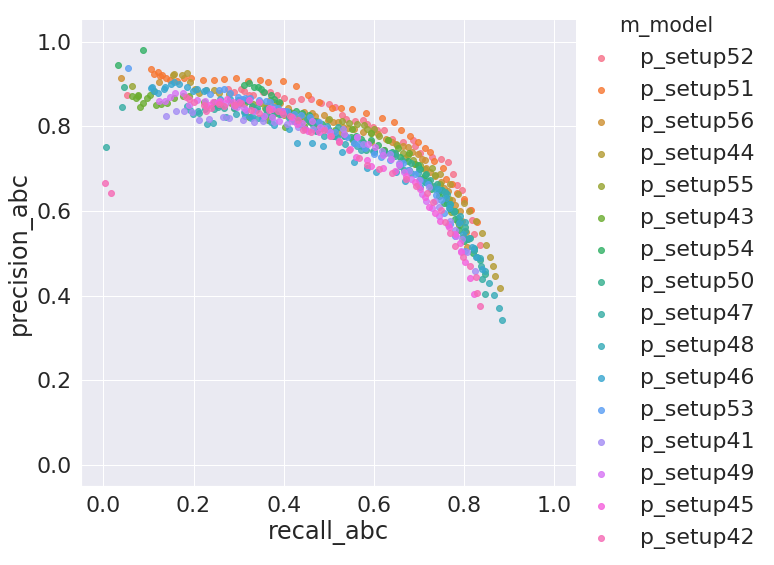

In [19]:
topmodels = len(model_best_set)
print(topmodels)
markers = ['o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd', '1', '2', '3', '4', '5', '6', '7', '8']
markers = markers[:topmodels]
print(len(markers))
new_df = pd.DataFrame()
for model, col, iteration, fscore_abc, score_thr, precision, recall in model_best_set[:topmodels]:
    filtered = df_seg[(df_seg['m_model'] == model) & (df_seg['synapse_collection'] == col) & (df_seg['m_iteration'] == iteration)]

    new_df = new_df.append(filtered)
    
sns.set(font_scale=2)
g = sns.lmplot(x='recall_abc', y='precision_abc', data=new_df, fit_reg=False, 
               height=8, aspect=1.1, 
               legend=True, hue='m_model')

plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
def print_pretty_settings(best_settings):
    for model, col, iteration, fscore_abc, score_thr, recall_abc, precision_abc in best_settings:
        print('\t \033[1m{}\033[0m best fscore: {:0.3f} --> {},{}, {:0.3f},'.format(model, fscore_abc, iteration, col,score_thr ))
        print('\t precision {:0.3f}, recall: {:0.3f}'.format(precision_abc, recall_abc))
print_pretty_settings(model_best_set[:topmodels])

Text(0.5, 1, 'Summary Gridsearch sorted: A,B,C weighted fsocre for each setup using neurons (same detection parameters)')

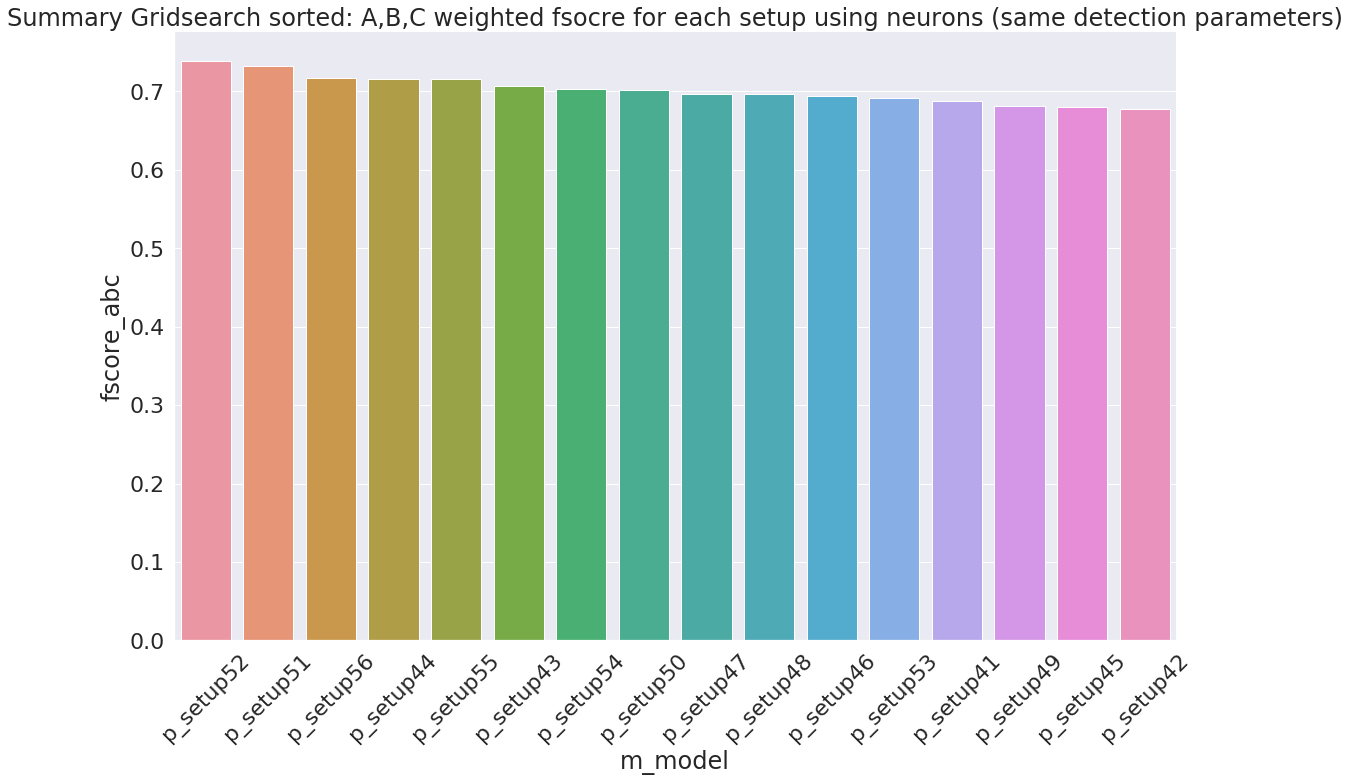

In [20]:
df_seg = df_f[df_f['filter_same_seg']==False]
idx = df_seg.groupby(['m_model'])['fscore_abc'].transform(max) == df_seg['fscore_abc']
filtered = df_seg[idx]
filtered = filtered.sort_values(by='fscore_abc', ascending=False)
sns.set(font_scale=2)
g = sns.catplot(x="m_model", y="fscore_abc", 
            data=filtered, kind='bar', 
            height=10, aspect=1.6, )
#             order=np.unique(df['m_model']))
g.set_xticklabels(rotation=45)

plt.title('Summary Gridsearch sorted: A,B,C weighted fsocre for each setup using neurons (same detection parameters)')

Text(0.5, 1, 'Best fscore over training iterations for all samples')

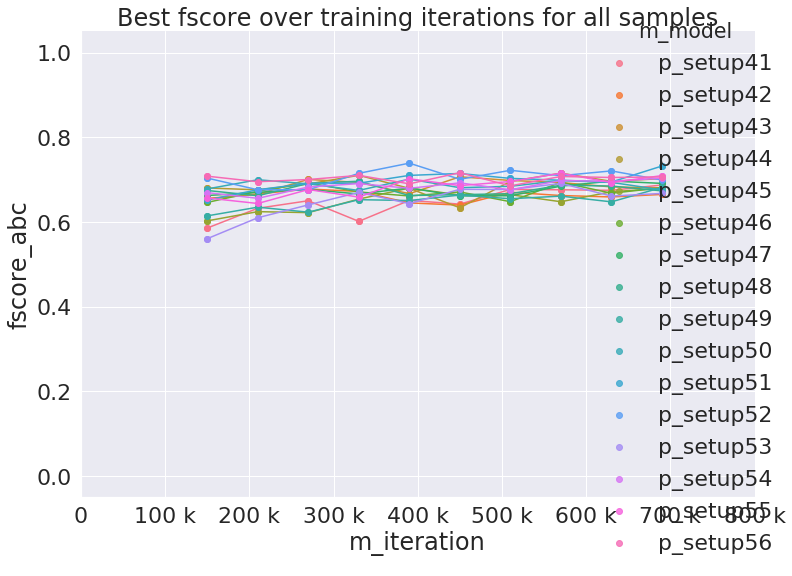

In [21]:
import matplotlib.ticker as ticker
df_model = df_f[(df_f['filter_same_seg']==False)]
res = df_model.groupby(['m_iteration', 'm_model'])['fscore_abc'].max()
res = res.reset_index() # Currently, the models are used as indeces, make the a column again
sns.set(font_scale=2)
g = sns.lmplot(x='m_iteration', y='fscore_abc', data=res, fit_reg=False, hue='m_model', 
               height=8, aspect=1.1, legend='full')
g.map(plt.plot, 'm_iteration', 'fscore_abc')
plt.ylim([-0.05, 1.05])
plt.xlim([0, 800000])
g.ax.xaxis.set_major_formatter(ticker.EngFormatter())
plt.title('Best fscore over training iterations for all samples')

best fscore: 0.7, precision: 0.71, recall: 0.7 with score threshold: 120.0
best fscore: 0.74, precision: 0.71, recall: 0.76 with score threshold: 90.0
best fscore: 0.68, precision: 0.67, recall: 0.69 with score threshold: 130.0


/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


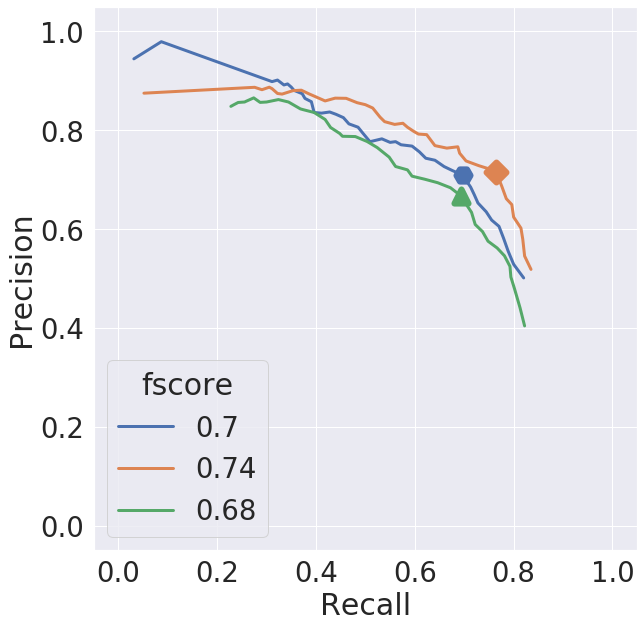

In [22]:
plt.figure(figsize=(10,10))

# Selected setups for Precision Recall Curve
# setups = [52, 56, 45]

# setup_label = {
#     'p_setup52': '0.73',
#     'p_setup51': '0.74',
#     'p_setup45': '0.68'
# }

new_df = pd.DataFrame()
for model, col, iteration, fscore_abc, score_thr, precision, recall in model_best_set:
    filtered = df_seg[(df_seg['m_model'] == model) & (df_seg['synapse_collection'] == col) & (df_seg['m_iteration'] == iteration)]
    new_df = new_df.append(filtered)
sns.set(font_scale=2.5)
setups = np.unique(df['m_model'])
# setups = ['p_setup52', 'p_setup56', 'p_setup45']
setups = ['p_setup54', 'p_setup52', 'p_setup45']
markers = ['H', 'D', '^', 'v', '^']
all_rows = []
for ii, setup in enumerate(setups):
    single_setup = new_df[new_df['m_model'] == setup]
#     plt.scatter(single_setup['recall_abc'], single_setup['precision_abc'])
    best_row = single_setup.loc[single_setup['fscore_abc'].idxmax()]
    fscore = best_row['fscore_abc']
    precision = best_row['precision_abc']
    recall = best_row['recall_abc']
    score_thr = best_row['score_thr']
    
    p = plt.plot(single_setup['recall_abc'], single_setup['precision_abc'], linewidth=3, label=f"{fscore:0.2}")
    
    plt.scatter(best_row['recall_abc'] + 0.00, best_row['precision_abc'] + 0.00, 
                s=200,marker=markers[ii], color=p[0].get_color(), linewidth=6.0)
    single_setup = single_setup[['fscore_abc', 'precision_abc', 'recall_abc', 'score_thr']]
    single_setup.to_csv(f'/nrs/funke/buhmannj/synfuldata/02supplfigure/gridsearch_without_neurons_curves_{setup}.csv', index=False)
    print(f"best fscore: {fscore:0.2}, precision: {precision:0.2}, recall: {recall:0.2} with score threshold: {score_thr}")
all_rows = pd.DataFrame(all_rows)
# all_rows.to_csv('/nrs/funke/buhmannj/synfuldata/02supplfigure/gridsearch_without_neurons_curves.csv', index=False)
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.axis('equal')
# plt.legend()
# plt.tight_layout()
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])
# plt.ylim([0.35, 1.05])
# plt.xlim([-0.0, 1.05])

plt.axes().set_aspect(1.0)
plt.legend(title='fscore')
# plt.savefig('figures/precision_recall_without_neurons.svg',dpi=300)

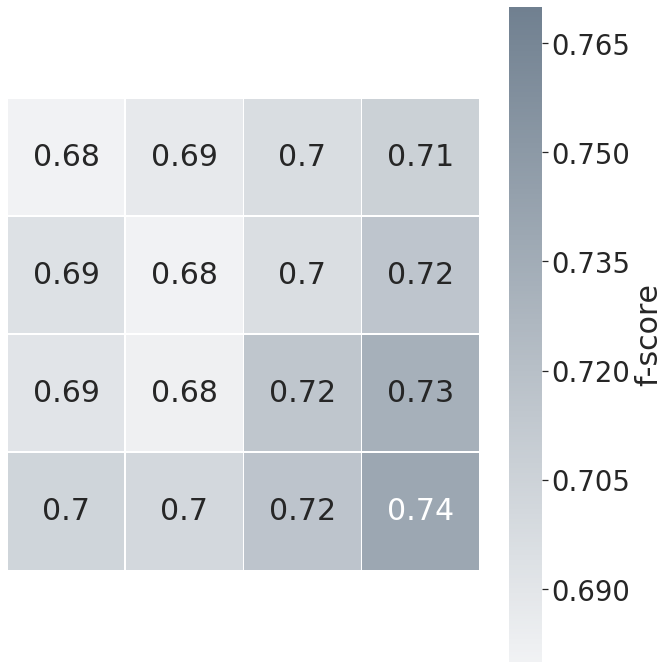

In [23]:
plt.figure(figsize=(10,10))
model_to_fscore = {}
for model, col, iteration, fscore_abc, score_thr, precision, recall in model_best_set:
    model_to_fscore[int(model[-2:])] = fscore_abc

## Now, prepare paper figure
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
row = [45, 41, 47, 43]
row2 = [46, 42, 48, 44]
row3 = [53, 49, 55, 51]
row4 = [54, 50, 56, 52]
sns.set(font_scale=2.5)
data = np.zeros((4, 4))
data[0, :] = np.array([model_to_fscore.get(model, None) for model in row])
data[1, :] = np.array([model_to_fscore.get(model, None) for model in row2])
data[2, :] = np.array([model_to_fscore.get(model, None) for model in row3])
data[3, :] = np.array([model_to_fscore.get(model, None) for model in row4])



cm = sns.light_palette('slategray', as_cmap=True)
helixcolor = sns.cubehelix_palette(15, start=0, rot=-.75)
sns.heatmap(data, yticklabels=False, xticklabels=False, annot=True, 
            cbar_kws={'label': r'f-score'}, linewidth=0.5, cmap=cm, vmin='0.68', vmax=0.77, fmt='.2g', square=True)
plt.tight_layout()
# plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('figures/gridsearch_heatmap_without_neurons.svg',dpi=300)
# fig.savefig('output.png')

In [24]:
# row = [45, 41, 47, 43]
# row2 = [46, 42, 48, 44]
# row3 = [53, 49, 55, 51]
# row4 = [54, 50, 56, 52]
idx = df_seg.groupby(['m_model'])['fscore_abc'].transform(max) == df_seg['fscore_abc']
df_seg = df_seg.sort_values(by='fscore_abc', ascending=False)
supp_table = df_seg[idx][['m_model', 'nms_radius', 'm_iteration', 'fscore_abc', 'score_thr', 'recall_abc', 'precision_abc', 'cc_threshold']]
m_model_param = {
    'p_setup45': {'size': 'small', 'balancing': 'standard', 'unet': 'MT2', 'loss': 'MSE'},
    'p_setup41': {'size': 'small', 'balancing': 'standard', 'unet': 'MT2', 'loss': 'CE'},
    'p_setup47': {'size': 'big', 'balancing': 'standard', 'unet': 'MT2', 'loss': 'MSE'},
    'p_setup43': {'size': 'big', 'balancing': 'standard', 'unet': 'MT2', 'loss': 'CE'},
    'p_setup46': {'size': 'small', 'balancing': 'standard', 'unet': 'ST', 'loss': 'MSE'},
    'p_setup42': {'size': 'small', 'balancing': 'standard', 'unet': 'ST', 'loss': 'CE'},
    'p_setup48': {'size': 'big', 'balancing': 'standard', 'unet': 'ST', 'loss': 'MSE'},
    'p_setup44': {'size': 'big', 'balancing': 'standard', 'unet': 'ST', 'loss': 'CE'},
    'p_setup53': {'size': 'small', 'balancing': 'curriculum', 'unet': 'MT2', 'loss': 'MSE'},
    'p_setup49': {'size': 'small', 'balancing': 'curriculum', 'unet': 'MT2', 'loss': 'CE'},
    'p_setup55': {'size': 'big', 'balancing': 'curriculum', 'unet': 'MT2', 'loss': 'MSE'},
    'p_setup51': {'size': 'big', 'balancing': 'curriculum', 'unet': 'MT2', 'loss': 'CE'},
    'p_setup54': {'size': 'small', 'balancing': 'curriculum', 'unet': 'ST', 'loss': 'MSE'},
    'p_setup50': {'size': 'small', 'balancing': 'curriculum', 'unet': 'ST', 'loss': 'CE'},
    'p_setup56': {'size': 'big', 'balancing': 'curriculum', 'unet': 'ST', 'loss': 'MSE'},
    'p_setup52': {'size': 'big', 'balancing': 'curriculum', 'unet': 'ST', 'loss': 'CE'},
}
print(len(m_model_param))
parameters = pd.DataFrame(m_model_param).transpose()
supp_table.set_index("m_model", inplace=True)
detailed_results = parameters.join(supp_table)
table_out = 'tables/gridsearch_without_neurons.csv'
detailed_results = detailed_results.loc[~detailed_results.index.duplicated(keep='last')] # p_setup48 has for three different nms radii same fscore, remove duplicates
detailed_results
# detailed_results.to_csv(table_out, index=False, na_rep='NA', float_format='%0.3f',columns=['size', 'balancing', 'unet', 'loss', 'fscore_abc', 'precision_abc', 'recall_abc', 'score_thr', 'nms_radius', 'cc_threshold'])

16


/groups/funke/home/buhmannj/anaconda2/envs/newdaisy/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,balancing,loss,size,unet,nms_radius,m_iteration,fscore_abc,score_thr,recall_abc,precision_abc,cc_threshold
p_setup45,standard,MSE,small,MT2,NaN,390000,0.680000,130.0,0.692593,0.667857,0.95
p_setup41,standard,CE,small,MT2,NaN,690000,0.687225,80.0,0.722222,0.655462,0.90
p_setup47,standard,MSE,big,MT2,NaN,630000,0.696534,110.0,0.762963,0.640747,0.80
p_setup43,standard,CE,big,MT2,NaN,450000,0.706564,100.0,0.677778,0.737903,0.95
p_setup46,standard,MSE,small,ST,NaN,570000,0.693772,80.0,0.742593,0.650974,0.95
p_setup42,standard,CE,small,ST,NaN,270000,0.677729,110.0,0.718519,0.641322,0.95
p_setup48,standard,MSE,big,ST,NaN,330000,0.696170,120.0,0.757407,0.644094,0.95
p_setup44,standard,CE,big,ST,NaN,570000,0.715173,120.0,0.746296,0.686542,0.90
p_setup53,curriculum,MSE,small,MT2,NaN,570000,0.690941,70.0,0.720370,0.663823,0.95
p_setup49,curriculum,CE,small,MT2,NaN,690000,0.681424,110.0,0.655556,0.709419,0.95
